In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score

import datetime

from warnings import filterwarnings
filterwarnings('ignore')

## Downloading Data

In [2]:
train = pd.read_csv("Datasets/train_dataset_hackathon_mkb.csv", sep = ';', encoding = 'cp1251')
test = pd.read_csv("Datasets/test_dataset_hackathon_mkb.csv", sep = ';', encoding = 'cp1251')

## Parsing OKTMO and OKVED:

In [3]:
train['OKVED_CODE'] = train['OKVED_CODE'].fillna("-1").transform(lambda x : x.split(".")[0]).replace({"-1" : "unknown"})
test['OKVED_CODE'] = test['OKVED_CODE'].fillna("-1").transform(lambda x : x.split(".")[0]).replace({"-1" : "unknown"})

In [4]:
train['OKTMO_CODE'] = train['OKTMO_CODE'].fillna("00000000000").astype(str).transform(lambda x : x[:2]).replace({"000" : "unknown"})
test['OKTMO_CODE'] = test['OKTMO_CODE'].fillna("00000000000").astype(str).transform(lambda x : x[:2]).replace({"000" : "unknown"})

In [5]:
train['OKTMO_CODE'].nunique()

79

## Transforming Datetime cols

In [6]:
dt = ['SIGN_DATE', 'DATEFIRSTREG', 'TAXREG_REGDATE', 'TAXREGPAY_REGDATE', 'BIRTHDATE']

In [7]:
def date_transformation(df):
    
    """
    Moves col from 'str' to 'datetime' type
    """
    
    for col in dt:
        
        if df[col].dtype == 'object':
            
            df[col] = df[col].str.replace(':00:00:00', '')
            df[col] = pd.to_datetime(df[col], format='%d%b%Y', errors='coerce')
            
date_transformation(train)
date_transformation(test)

## Transforming Categorial Cols

In [8]:
ct = train.columns[train.dtypes == 'object']
ct

Index(['OKFS_GROUP', 'OKOPF_GROUP', 'OKOGU_GROUP', 'OKTMO_CODE',
       'WORKERSRANGE', 'OKVED_CODE', 'SEX_NAME', 'CITIZENSHIP_NAME'],
      dtype='object')

In [9]:
train[ct] = train[ct].fillna('unknown')
test[ct] = test[ct].fillna('unknown')

In [10]:
F_cols = [col for col in train.columns if "F1" == col[:2] or "F2" == col[:2]]
train[F_cols].fillna(0, inplace = True)
test[F_cols].fillna(0, inplace = True)

## Dataset Transformations:

In [11]:
def transformations(df, train_flg = True):
    
    # времени с прошедших n заявок
    for i in range(-4, 5):
        
        if i != 0:
            df['SIGN_DATE_diff' + str(i)] = df.groupby('id_client')['SIGN_DATE'].diff(i).fillna(pd.Timedelta(0)).astype(int).reset_index(level = 0, drop = True)
    
    df['mean_time_diff'] = df.groupby('id_client')['SIGN_DATE_diff1'].transform('mean')
    df['app_num'] = df.groupby('id_client').cumcount()
    
    early_time = pd.to_datetime('2018-01-01').value
    
    for col in dt[:-1]:
        
        df[col + "_day"] = df[col].transform(lambda x : x.weekday()).fillna(0).astype(int)
        df[col + '_month'] = df[col].transform(lambda x : x.month).fillna(0).astype(int)
        df[col + "_num"] = df[col].apply(lambda x : x.value - early_time)
    
    return df

In [12]:
train = transformations(train, train_flg = True)
test = transformations(test, train_flg = False)

## CatBoost

In [13]:
del_cols = [] #['FLAG_DISQUALIFICATION', 'SUM_95_EVER', 'F1400', 'F1410']

In [14]:
feat_cols = [col for col in train.columns if col not in (['id_contract', 'TARGET'] + dt + del_cols)]

In [15]:
feat_cols.__len__()

139

In [16]:
train[feat_cols].dtypes

id_client                    int64
IP_flag                      int64
F1100                      float64
F1110                      float64
F1150                      float64
                            ...   
TAXREG_REGDATE_month         int64
TAXREG_REGDATE_num          object
TAXREGPAY_REGDATE_day        int64
TAXREGPAY_REGDATE_month      int64
TAXREGPAY_REGDATE_num       object
Length: 139, dtype: object

In [17]:
model = CatBoostClassifier(cat_features=ct.to_list(), objective='Logloss')

In [18]:
model.fit(train[feat_cols], train['TARGET'])

Learning rate set to 0.035303
0:	learn: 0.6634310	total: 123ms	remaining: 2m 3s
1:	learn: 0.6379792	total: 147ms	remaining: 1m 13s
2:	learn: 0.6081221	total: 171ms	remaining: 56.8s
3:	learn: 0.5857160	total: 189ms	remaining: 47s
4:	learn: 0.5627636	total: 210ms	remaining: 41.9s
5:	learn: 0.5426037	total: 230ms	remaining: 38.1s
6:	learn: 0.5261944	total: 251ms	remaining: 35.6s
7:	learn: 0.5070185	total: 270ms	remaining: 33.5s
8:	learn: 0.4914137	total: 291ms	remaining: 32.1s
9:	learn: 0.4779241	total: 308ms	remaining: 30.5s
10:	learn: 0.4618919	total: 330ms	remaining: 29.6s
11:	learn: 0.4480947	total: 349ms	remaining: 28.7s
12:	learn: 0.4369691	total: 372ms	remaining: 28.3s
13:	learn: 0.4269251	total: 389ms	remaining: 27.4s
14:	learn: 0.4162790	total: 410ms	remaining: 26.9s
15:	learn: 0.4087108	total: 428ms	remaining: 26.3s
16:	learn: 0.3979289	total: 450ms	remaining: 26s
17:	learn: 0.3898115	total: 472ms	remaining: 25.8s
18:	learn: 0.3830814	total: 494ms	remaining: 25.5s
19:	learn: 0.3

170:	learn: 0.2286231	total: 3.53s	remaining: 17.1s
171:	learn: 0.2283930	total: 3.55s	remaining: 17.1s
172:	learn: 0.2281858	total: 3.58s	remaining: 17.1s
173:	learn: 0.2276464	total: 3.6s	remaining: 17.1s
174:	learn: 0.2274436	total: 3.62s	remaining: 17s
175:	learn: 0.2273201	total: 3.63s	remaining: 17s
176:	learn: 0.2270652	total: 3.66s	remaining: 17s
177:	learn: 0.2268937	total: 3.67s	remaining: 17s
178:	learn: 0.2267043	total: 3.69s	remaining: 16.9s
179:	learn: 0.2265361	total: 3.71s	remaining: 16.9s
180:	learn: 0.2262939	total: 3.73s	remaining: 16.9s
181:	learn: 0.2261264	total: 3.75s	remaining: 16.9s
182:	learn: 0.2259180	total: 3.78s	remaining: 16.9s
183:	learn: 0.2257536	total: 3.8s	remaining: 16.8s
184:	learn: 0.2255510	total: 3.82s	remaining: 16.8s
185:	learn: 0.2253934	total: 3.84s	remaining: 16.8s
186:	learn: 0.2252043	total: 3.86s	remaining: 16.8s
187:	learn: 0.2249771	total: 3.88s	remaining: 16.7s
188:	learn: 0.2247320	total: 3.9s	remaining: 16.7s
189:	learn: 0.2245124	t

333:	learn: 0.2025785	total: 6.95s	remaining: 13.8s
334:	learn: 0.2024518	total: 6.97s	remaining: 13.8s
335:	learn: 0.2021794	total: 6.99s	remaining: 13.8s
336:	learn: 0.2020083	total: 7.01s	remaining: 13.8s
337:	learn: 0.2017547	total: 7.03s	remaining: 13.8s
338:	learn: 0.2015422	total: 7.05s	remaining: 13.7s
339:	learn: 0.2014132	total: 7.07s	remaining: 13.7s
340:	learn: 0.2013086	total: 7.09s	remaining: 13.7s
341:	learn: 0.2011151	total: 7.11s	remaining: 13.7s
342:	learn: 0.2009013	total: 7.13s	remaining: 13.7s
343:	learn: 0.2007776	total: 7.14s	remaining: 13.6s
344:	learn: 0.2006795	total: 7.17s	remaining: 13.6s
345:	learn: 0.2006579	total: 7.19s	remaining: 13.6s
346:	learn: 0.2005868	total: 7.21s	remaining: 13.6s
347:	learn: 0.2004945	total: 7.22s	remaining: 13.5s
348:	learn: 0.2004169	total: 7.24s	remaining: 13.5s
349:	learn: 0.2002985	total: 7.26s	remaining: 13.5s
350:	learn: 0.2002256	total: 7.28s	remaining: 13.5s
351:	learn: 0.2001050	total: 7.3s	remaining: 13.4s
352:	learn: 0

495:	learn: 0.1852395	total: 10.1s	remaining: 10.3s
496:	learn: 0.1851918	total: 10.2s	remaining: 10.3s
497:	learn: 0.1851121	total: 10.2s	remaining: 10.3s
498:	learn: 0.1849885	total: 10.2s	remaining: 10.2s
499:	learn: 0.1848104	total: 10.2s	remaining: 10.2s
500:	learn: 0.1846408	total: 10.2s	remaining: 10.2s
501:	learn: 0.1844764	total: 10.3s	remaining: 10.2s
502:	learn: 0.1844103	total: 10.3s	remaining: 10.2s
503:	learn: 0.1843431	total: 10.3s	remaining: 10.1s
504:	learn: 0.1842763	total: 10.3s	remaining: 10.1s
505:	learn: 0.1841167	total: 10.3s	remaining: 10.1s
506:	learn: 0.1840430	total: 10.4s	remaining: 10.1s
507:	learn: 0.1839127	total: 10.4s	remaining: 10.1s
508:	learn: 0.1838488	total: 10.4s	remaining: 10s
509:	learn: 0.1836837	total: 10.4s	remaining: 10s
510:	learn: 0.1835923	total: 10.4s	remaining: 9.99s
511:	learn: 0.1835088	total: 10.5s	remaining: 9.97s
512:	learn: 0.1835050	total: 10.5s	remaining: 9.95s
513:	learn: 0.1834589	total: 10.5s	remaining: 9.93s
514:	learn: 0.18

656:	learn: 0.1704670	total: 13.4s	remaining: 6.97s
657:	learn: 0.1704437	total: 13.4s	remaining: 6.96s
658:	learn: 0.1703175	total: 13.4s	remaining: 6.93s
659:	learn: 0.1702390	total: 13.4s	remaining: 6.91s
660:	learn: 0.1701161	total: 13.4s	remaining: 6.89s
661:	learn: 0.1700033	total: 13.5s	remaining: 6.87s
662:	learn: 0.1698616	total: 13.5s	remaining: 6.85s
663:	learn: 0.1697892	total: 13.5s	remaining: 6.83s
664:	learn: 0.1696693	total: 13.5s	remaining: 6.81s
665:	learn: 0.1696252	total: 13.5s	remaining: 6.79s
666:	learn: 0.1695413	total: 13.6s	remaining: 6.77s
667:	learn: 0.1693671	total: 13.6s	remaining: 6.75s
668:	learn: 0.1692522	total: 13.6s	remaining: 6.73s
669:	learn: 0.1691510	total: 13.6s	remaining: 6.71s
670:	learn: 0.1690499	total: 13.6s	remaining: 6.69s
671:	learn: 0.1689793	total: 13.7s	remaining: 6.67s
672:	learn: 0.1688786	total: 13.7s	remaining: 6.65s
673:	learn: 0.1687785	total: 13.7s	remaining: 6.63s
674:	learn: 0.1686756	total: 13.7s	remaining: 6.61s
675:	learn: 

816:	learn: 0.1572787	total: 16.6s	remaining: 3.71s
817:	learn: 0.1571739	total: 16.6s	remaining: 3.69s
818:	learn: 0.1571316	total: 16.6s	remaining: 3.67s
819:	learn: 0.1570540	total: 16.6s	remaining: 3.65s
820:	learn: 0.1569978	total: 16.7s	remaining: 3.63s
821:	learn: 0.1569404	total: 16.7s	remaining: 3.61s
822:	learn: 0.1568953	total: 16.7s	remaining: 3.59s
823:	learn: 0.1568148	total: 16.7s	remaining: 3.57s
824:	learn: 0.1567785	total: 16.7s	remaining: 3.55s
825:	learn: 0.1566510	total: 16.7s	remaining: 3.53s
826:	learn: 0.1565803	total: 16.8s	remaining: 3.51s
827:	learn: 0.1565349	total: 16.8s	remaining: 3.49s
828:	learn: 0.1564134	total: 16.8s	remaining: 3.47s
829:	learn: 0.1563828	total: 16.8s	remaining: 3.45s
830:	learn: 0.1562862	total: 16.9s	remaining: 3.43s
831:	learn: 0.1562168	total: 16.9s	remaining: 3.41s
832:	learn: 0.1561416	total: 16.9s	remaining: 3.39s
833:	learn: 0.1561101	total: 16.9s	remaining: 3.37s
834:	learn: 0.1560140	total: 16.9s	remaining: 3.35s
835:	learn: 

977:	learn: 0.1477144	total: 19.8s	remaining: 445ms
978:	learn: 0.1476166	total: 19.8s	remaining: 425ms
979:	learn: 0.1475399	total: 19.8s	remaining: 404ms
980:	learn: 0.1475120	total: 19.8s	remaining: 384ms
981:	learn: 0.1474775	total: 19.9s	remaining: 364ms
982:	learn: 0.1474470	total: 19.9s	remaining: 344ms
983:	learn: 0.1473594	total: 19.9s	remaining: 323ms
984:	learn: 0.1473052	total: 19.9s	remaining: 303ms
985:	learn: 0.1471753	total: 19.9s	remaining: 283ms
986:	learn: 0.1470927	total: 20s	remaining: 263ms
987:	learn: 0.1470263	total: 20s	remaining: 243ms
988:	learn: 0.1469460	total: 20s	remaining: 222ms
989:	learn: 0.1468991	total: 20s	remaining: 202ms
990:	learn: 0.1467497	total: 20s	remaining: 182ms
991:	learn: 0.1466173	total: 20.1s	remaining: 162ms
992:	learn: 0.1465157	total: 20.1s	remaining: 142ms
993:	learn: 0.1464820	total: 20.1s	remaining: 121ms
994:	learn: 0.1464209	total: 20.1s	remaining: 101ms
995:	learn: 0.1463356	total: 20.1s	remaining: 80.9ms
996:	learn: 0.1463115

In [19]:
test['TARGET'] = model.predict_proba(test[feat_cols])[:, 1]

In [20]:
test[['id_contract', 'TARGET']].to_csv('submission.csv', sep=';', index=False)

## Feature Importance

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1.35)

In [24]:
importances = np.array(model.feature_importances_)
names = np.array(model.feature_names_)

In [27]:
order = np.argsort(importances)

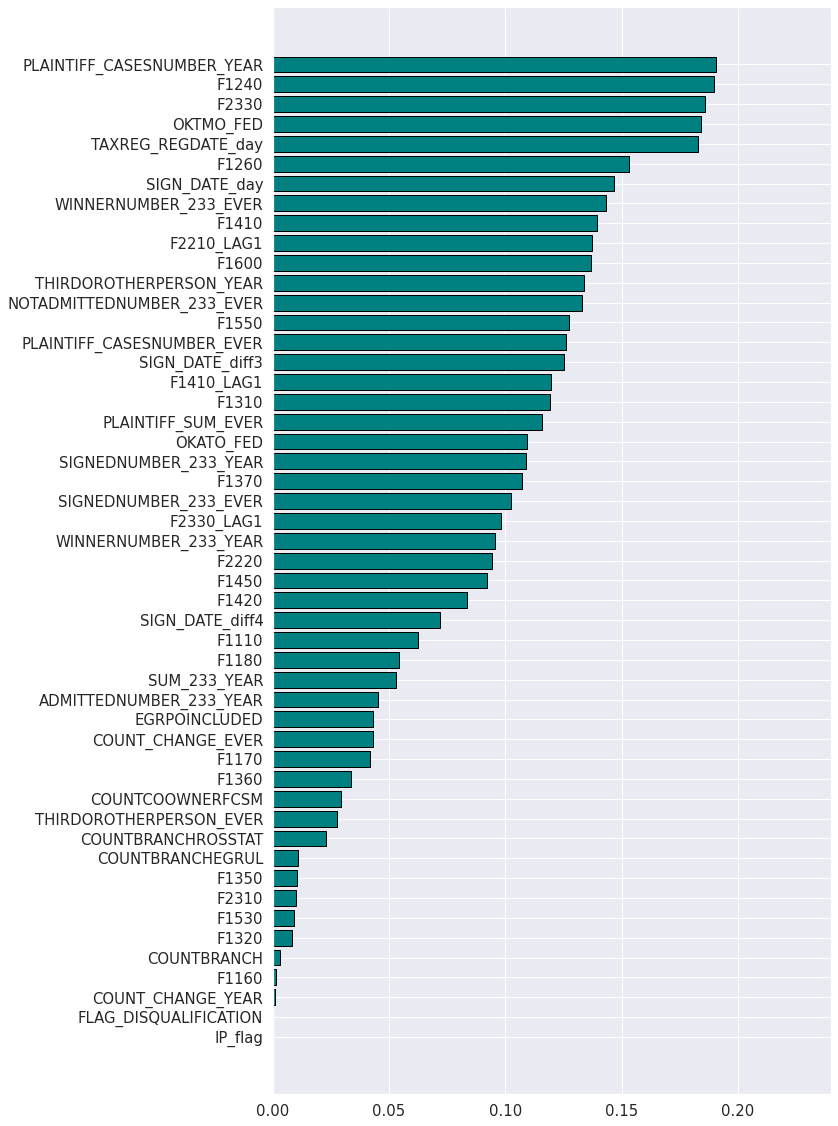

In [38]:
plt.figure(figsize = [10, 20])

plt.barh(np.arange(names.__len__())[:50], importances[order][:50], edgecolor = 'black', color = 'teal')
plt.xlim(0, 0.24)
plt.yticks(np.arange(names.__len__())[:50], names[order][:50])

plt.show()

## Нелегально, но дает около 0.002 буста на паблике

In [ ]:
exemp = pd.DataFrame.copy(test)

In [ ]:
exemp[['id_client', 'TARGET']]

In [ ]:
train = pd.read_csv("Datasets/train_dataset_hackathon_mkb.csv", sep = ';', encoding = 'cp1251')

In [ ]:
intersect = set(exemp['id_client']) & set(train['id_client'])

In [ ]:
active_ids = (train.groupby('id_client')['id_contract'].count() > 5).keys()[(train.groupby('id_client')['id_contract'].count() > 5).values]

In [ ]:
len(set(active_ids) & intersect)

In [ ]:
their_values = train.groupby('id_client')['TARGET'].mean()[(train.groupby('id_client')['id_contract'].count() > 5)].values

In [ ]:
their_values[(their_values > 0.95)] = 1
their_values[(their_values < 0.05)] = 0

In [ ]:
kept_ones = (their_values == 1) | (their_values == 0)

In [ ]:
active_ids = active_ids[kept_ones]
their_values = their_values[kept_ones]

In [ ]:
active_ids.shape, their_values.shape

In [ ]:
sub_df = pd.DataFrame(np.array([active_ids, their_values]).T, columns = ['id_client', 'TARGET_new'])

In [ ]:
exemp = exemp.merge(sub_df, how = 'left')

In [ ]:
exemp.loc[~exemp['TARGET_new'].isna(), 'TARGET'] = exemp.loc[~exemp['TARGET_new'].isna(), 'TARGET_new']

In [ ]:
exemp[['id_contract', 'TARGET']].to_csv("submission_v2.csv", sep = ';', index = False)